##### Copyright 2020 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Build, train and evaluate models with TensorFlow Decision Forests

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/beginner_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/beginner_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


## Introduction

Decision Forests (DF) are a large family of Machine Learning algorithms for
supervised classification, regression and ranking. As the name suggests, DFs use
decision trees as a building block. Today, the two most popular DF training
algorithms are [Random Forests](https://en.wikipedia.org/wiki/Random_forest) and
[Gradient Boosted Decision Trees](https://en.wikipedia.org/wiki/Gradient_boosting). Both algorithms are ensemble techniques that use multiple decision trees, but differ on how they do it.

TensorFlow Decision Forests (TF-DF) is a library for the training,
evaluation, interpretation and inference of Decision Forest models.

In this tutorial, you will learn how to:

1.  Train a binary classification Random Forest on a dataset containing numerical, categorical and missing features.
1.  Evaluate the model on a test dataset.
1.  Prepare the model for
    [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).
1.  Examine the overall structure of the model and the importance of each feature.
1.  Re-train the model with a different learning algorithm (Gradient Boosted Decision Trees).
1.  Use a different set of input features.
1.  Change the hyperparameters of the model.
1.  Preprocess the features.
1.  Train a model for regression.
1.  Train a model for ranking.

Detailed documentation is available in the [user manual](https://github.com/tensorflow/decision-forests/tree/main/documentation).
The [example directory](https://github.com/tensorflow/decision-forests/examples) contains other end-to-end examples.

## Installing TensorFlow Decision Forests

Install TF-DF by running the following cell.

In [5]:
!pip install tensorflow

In [6]:
pip install tensorflow_decision_forests

ERROR: Could not find a version that satisfies the requirement tensorflow_decision_forests (from versions: none)
ERROR: No matching distribution found for tensorflow_decision_forests


[Wurlitzer](https://pypi.org/project/wurlitzer/) is needed to display the detailed training logs in Colabs (when using `verbose=2` in the model constructor).

In [5]:
pip install wurlitzer

Note: you may need to restart the kernel to use updated packages.


## Importing libraries

In [1]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

ModuleNotFoundError: No module named 'tensorflow_decision_forests'

The hidden code cell limits the output height in colab.


In [5]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

In [6]:
# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

Found TensorFlow Decision Forests v0.2.4


## Training a Random Forest model

In this section, we train, evaluate, analyse and export a binary classification Random Forest trained on the [Palmer's Penguins](https://allisonhorst.github.io/palmerpenguins/articles/intro.html) dataset.

<center>
<img src="https://allisonhorst.github.io/palmerpenguins/man/figures/palmerpenguins.png" width="150"/></center>

**Note:** The dataset was exported to a csv file without pre-processing: `library(palmerpenguins); write.csv(penguins, file="penguins.csv", quote=F, row.names=F)`. 

### Load the dataset and convert it in a tf.Dataset

This dataset is very small (300 examples) and stored as a .csv-like file. Therefore, use Pandas to load it.

**Note:** Pandas is practical as you don't have to type in name of the input features to load them. For larger datasets (>1M examples), using the
[TensorFlow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) to read the files may be better suited.

Let's assemble the dataset into a csv file (i.e. add the header), and load it:

In [7]:
# Download the dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/palmer_penguins/penguins.csv -O /tmp/penguins.csv

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv("/tmp/penguins.csv")

# Display the first 3 examples.
dataset_df.head(3)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007


The dataset contains a mix of numerical (e.g. `bill_depth_mm`), categorical
(e.g. `island`) and missing features. TF-DF supports all these feature types natively (differently than NN based models), therefore there is no need for preprocessing in the form of one-hot encoding, normalization or extra `is_present` feature.

Labels are a bit different: Keras metrics expect integers. The label (`species`) is stored as a string, so let's convert it into an integer.

In [8]:
# Encode the categorical label into an integer.
#
# Details:
# This stage is necessary if your classification label is represented as a
# string. Note: Keras expected classification labels to be integers.

# Name of the label column.
label = "species"

classes = dataset_df[label].unique().tolist()
print(f"Label classes: {classes}")

dataset_df[label] = dataset_df[label].map(classes.index)

Label classes: ['Adelie', 'Gentoo', 'Chinstrap']


Next split the dataset into training and testing:

In [9]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

236 examples in training, 108 examples for testing.


And finally, convert the pandas dataframe (`pd.Dataframe`) into tensorflow datasets (`tf.data.Dataset`):

In [10]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label)

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


**Notes:** `pd_dataframe_to_tf_dataset` could have converted the label to integer for you.

And, if you wanted to create the `tf.data.Dataset` yourself, there is a couple of things to remember:

- The learning algorithms work with a one-epoch dataset and without shuffling.
- The batch size does not impact the training algorithm, but a small value might slow down reading the dataset.


### Train the model

In [11]:
%set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel()

# Train the model.
model_1.fit(x=train_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmp6me1pn0g as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:03.315373
Training model
Model trained in 0:00:00.025709
Compiling model
1/1 [==============================] - 3s 3s/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


### Remarks

-   No input features are specified. Therefore, all the columns will be used as
    input features except for the label. The feature used by the model are shown
    in the training logs and in the `model.summary()`.
-   DFs consume natively numerical, categorical, categorical-set features and
    missing-values. Numerical features do not need to be normalized. Categorical
    string values do not need to be encoded in a dictionary.
-   No training hyper-parameters are specified. Therefore the default
    hyper-parameters will be used. Default hyper-parameters provide
    reasonable results in most situations.
-   Calling `compile` on the model before the `fit` is optional. Compile can be
    used to provide extra evaluation metrics.
-   Training algorithms do not need validation datasets. If a validation dataset
    is provided, it will only be used to show metrics.
-   Add a `verbose` argument to `RandomForestModel` to control the amount of
    displayed training logs. Set `verbose=0` to hide most of the logs. Set 
    `verbose=2` to show all the logs.

**Note:** A *Categorical-Set* feature is composed of a set of categorical values (while a *Categorical* is only one value). More details and examples are given later.

## Evaluate the model

Let's evaluate our model on the test dataset.

In [12]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 0s 292ms/step - loss: 0.0000e+00 - accuracy: 1.0000

loss: 0.0000
accuracy: 1.0000


**Remark:** The test accuracy (0.86514) is close to the Out-of-bag accuracy
(0.8672) shown in the training logs.

See the **Model Self Evaluation** section below for more evaluation methods.

## Prepare this model for TensorFlow Serving.

Export the model to the SavedModel format for later re-use e.g.
[TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving).


In [13]:
model_1.save("/tmp/my_saved_model")

2022-04-19 11:16:01.402841: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


INFO:tensorflow:Assets written to: /tmp/my_saved_model/assets


## Plot the model

Plotting a decision tree and following the first branches helps learning about decision forests. In some cases, plotting a model can even be used for debugging.

Because of the difference in the way they are trained, some models are more interresting to plan than others. Because of the noise injected during training and the depth of the trees, plotting Random Forest is less informative than plotting a CART or the first tree of a Gradient Boosted Tree.

Never the less, let's plot the first tree of our Random Forest model:

In [14]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=0, max_depth=3)

The root node on the left contains the first condition (`bill_depth_mm >= 16.55`), number of examples (240) and label distribution (the red-blue-green bar).

Examples that evaluates true to `bill_depth_mm >= 16.55` are branched to the green path. The other ones are branched to the red path.

The deeper the node, the more `pure` they become i.e. the label distribution is biased toward a subset of classes. 

**Note:** Over the mouse on top of the plot for details.

## Model tructure and feature importance

The overall structure of the model is show with `.summary()`. You will see:

-   **Type**: The learning algorithm used to train the model (`Random Forest` in
    our case).
-   **Task**: The problem solved by the model (`Classification` in our case).
-   **Input Features**: The input features of the model.
-   **Variable Importance**: Different measures of the importance of each
    feature for the model.
-   **Out-of-bag evaluation**: The out-of-bag evaluation of the model. This is a
    cheap and efficient alternative to cross-validation.
-   **Number of {trees, nodes} and other metrics**: Statistics about the
    structure of the decisions forests.

**Remark:** The summary's content depends on the learning algorithm (e.g.
Out-of-bag is only available for Random Forest) and the hyper-parameters (e.g.
the *mean-decrease-in-accuracy* variable importance can be disabled in the
hyper-parameters).

In [15]:
%set_cell_height 300
model_1.summary()

<IPython.core.display.Javascript object>

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (7):
	bill_depth_mm
	bill_length_mm
	body_mass_g
	flipper_length_mm
	island
	sex
	year

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.           "__LABEL"  3.280961 ################
    2.              "year"  3.260605 ###############
    3.               "sex"  3.207424 ###############
    4.       "body_mass_g"  2.809716 ############
    5.            "island"  2.144323 #######
    6.     "bill_depth_mm"  2.056055 ######
    7. "flipper_length_mm"  1.616061 ###
    8.    "bill_length_mm"  1.201421 

Variable Importance: NUM_AS_ROOT:
    1. "flipper_length_mm" 120.000000 ################
    2.    "bill_length_mm" 93.00

The information in ``summary`` are all available programatically using the model inspector:

In [16]:
# The input features
model_1.make_inspector().features()

["bill_depth_mm" (1; #0),
 "bill_length_mm" (1; #1),
 "body_mass_g" (1; #2),
 "flipper_length_mm" (1; #3),
 "island" (4; #4),
 "sex" (4; #5),
 "year" (1; #6)]

In [17]:
# The feature importances
model_1.make_inspector().variable_importances()

{'NUM_AS_ROOT': [("flipper_length_mm" (1; #3), 120.0),
  ("bill_length_mm" (1; #1), 93.0),
  ("bill_depth_mm" (1; #0), 70.0),
  ("island" (4; #4), 16.0),
  ("body_mass_g" (1; #2), 1.0)],
 'MEAN_MIN_DEPTH': [("__LABEL" (4; #7), 3.280960604210599),
  ("year" (1; #6), 3.2606045898545846),
  ("sex" (4; #5), 3.207423927923923),
  ("body_mass_g" (1; #2), 2.809716228216225),
  ("island" (4; #4), 2.1443225755725748),
  ("bill_depth_mm" (1; #0), 2.0560545380545374),
  ("flipper_length_mm" (1; #3), 1.6160606800606798),
  ("bill_length_mm" (1; #1), 1.2014205146705157)],
 'SUM_SCORE': [("bill_length_mm" (1; #1), 26762.987352006137),
  ("flipper_length_mm" (1; #3), 18170.776540881954),
  ("bill_depth_mm" (1; #0), 11901.538405206986),
  ("island" (4; #4), 11507.26736571081),
  ("body_mass_g" (1; #2), 2007.0397834228352),
  ("sex" (4; #5), 385.18135726079345),
  ("year" (1; #6), 44.290259033441544)],
 'NUM_NODES': [("bill_length_mm" (1; #1), 715.0),
  ("bill_depth_mm" (1; #0), 390.0),
  ("flipper_len

The content of the summary and the inspector depends on the learning algorithm (`tfdf.keras.RandomForestModel` in this case) and its hyper-parameters (e.g. `compute_oob_variable_importances=True` will trigger the computation of Out-of-bag variable importances for the Random Forest learner).

## Model Self Evaluation

During training TFDF models can self evaluate even if no validation dataset is provided to the `fit()` method. The exact logic depends on the model. For example, Random Forest will use Out-of-bag evaluation while Gradient Boosted Trees will use internal train-validation.

**Note:** While this evaluation is  computed during training, it is NOT computed on the training dataset and can be used as a low quality evaluation.

The model self evaluation is available with the inspector's `evaluation()`:

In [18]:
model_1.make_inspector().evaluation()

Evaluation(num_examples=236, accuracy=0.9745762711864406, loss=0.10867847165613735, rmse=None, ndcg=None, aucs=None)

## Plotting the training logs

The training logs show the quality of the model (e.g. accuracy evaluated on the out-of-bag or validation dataset) according to the number of trees in the model. These logs are helpful to study the balance between model size and model quality.

The logs are available in multiple ways:

1. Displayed in during training if `fit()` is wrapped in `with sys_pipes():` (see example above).
1. At the end of the model summary i.e. `model.summary()` (see example above).
1. Programmatically, using the model inspector i.e. `model.make_inspector().training_logs()`.
1. Using [TensorBoard](https://www.tensorflow.org/tensorboard)

Let's try the options 2 and 3:


In [19]:
%set_cell_height 150
model_1.make_inspector().training_logs()

<IPython.core.display.Javascript object>

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=86, accuracy=0.9418604651162791, loss=2.095561138419218, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=12, evaluation=Evaluation(num_examples=235, accuracy=0.9404255319148936, loss=1.284872737336666, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=22, evaluation=Evaluation(num_examples=236, accuracy=0.9533898305084746, loss=0.39048642611478346, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=32, evaluation=Evaluation(num_examples=236, accuracy=0.9745762711864406, loss=0.3910905674920749, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=42, evaluation=Evaluation(num_examples=236, accuracy=0.9788135593220338, loss=0.38650180805095674, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=52, evaluation=Evaluation(num_examples=236, accuracy=0.9745762711864406, loss=0.38776641405361184, rmse=None, ndcg=None, aucs=None)),
 TrainLog(num_trees=62, evaluation=Evaluation(num_examples=236, accuracy=0.97457627

Let's plot it:

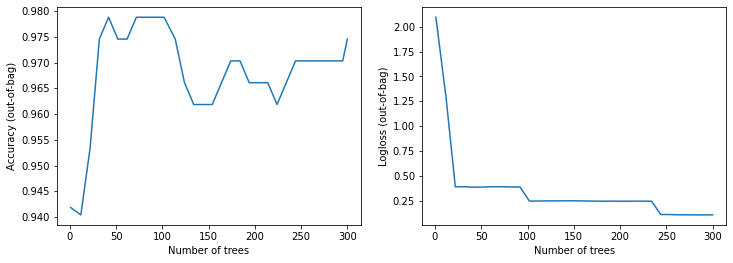

In [20]:
import matplotlib.pyplot as plt

logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

This dataset is small. You can see the model converging almost immediately.

Let's use TensorBoard:

In [21]:
# This cell start TensorBoard that can be slow.
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Google internal version
# %load_ext google3.learning.brain.tensorboard.notebook.extension

In [22]:
# Clear existing results (if any)
!rm -fr "/tmp/tensorboard_logs"

In [23]:
# Export the meta-data to tensorboard.
model_1.make_inspector().export_to_tensorboard("/tmp/tensorboard_logs")

In [ ]:
# docs_infra: no_execute
# Start a tensorboard instance.
%tensorboard --logdir "/tmp/tensorboard_logs"

<!-- <img class="tfo-display-only-on-site" src="images/beginner_tensorboard.png"/> -->


## Re-train the model with a different learning algorithm

The learning algorithm is defined by the model class. For
example, `tfdf.keras.RandomForestModel()` trains a Random Forest, while
`tfdf.keras.GradientBoostedTreesModel()` trains a Gradient Boosted Decision
Trees.

The learning algorithms are listed by calling `tfdf.keras.get_all_models()` or in the
[learner list](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/learners.md).

In [24]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

The description of the learning algorithms and their hyper-parameters are also available in the [API reference](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf) and builtin help:

In [25]:
# help works anywhere.
help(tfdf.keras.RandomForestModel)

# ? only works in ipython or notebooks, it usually opens on a separate panel.
tfdf.keras.RandomForestModel?

Help on class RandomForestModel in module tensorflow_decision_forests.keras:

class RandomForestModel(tensorflow_decision_forests.keras.wrappers.RandomForestModel)
 |  RandomForestModel(*args, **kwargs)
 |  
 |  Random Forest learning algorithm.
 |  
 |  A Random Forest (https://www.stat.berkeley.edu/~breiman/randomforest2001.pdf)
 |  is a collection of deep CART decision trees trained independently and without
 |  pruning. Each tree is trained on a random subset of the original training 
 |  dataset (sampled with replacement).
 |  
 |  The algorithm is unique in that it is robust to overfitting, even in extreme
 |  cases e.g. when there is more features than training examples.
 |  
 |  It is probably the most well-known of the Decision Forest training
 |  algorithms.
 |  
 |  Usage example:
 |  
 |  ```python
 |  import tensorflow_decision_forests as tfdf
 |  import pandas as pd
 |  
 |  dataset = pd.read_csv("project/dataset.csv")
 |  tf_dataset = tfdf.keras.pd_dataframe_to_tf_datase

## Using a subset of features

The previous example did not specify the features, so all the columns were used
as input feature (except for the label). The following example shows how to
specify input features.

In [26]:
feature_1 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature_2 = tfdf.keras.FeatureUsage(name="island")

all_features = [feature_1, feature_2]

# Note: This model is only trained with two features. It will not be as good as
# the one trained on all features.

model_2 = tfdf.keras.GradientBoostedTreesModel(
    features=all_features, exclude_non_specified_features=True)

model_2.compile(metrics=["accuracy"])
model_2.fit(x=train_ds, validation_data=test_ds)

print(model_2.evaluate(test_ds, return_dict=True))

Use /tmp/tmppf8e7g5_ as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.218573
Training model
Model trained in 0:00:00.242015
Compiling model
1/1 [==============================] - 1s 608ms/step - val_loss: 0.0000e+00 - val_accuracy: 0.9722


[INFO kernel.cc:1153] Loading model from path
[INFO kernel.cc:1001] Use fast generic engine


1/1 [==============================] - 0s 79ms/step - loss: 0.0000e+00 - accuracy: 0.9722
{'loss': 0.0, 'accuracy': 0.9722222089767456}


**Note:** As expected, the accuracy is lower than previously.

**TF-DF** attaches a **semantics** to each feature. This semantics controls how
the feature is used by the model. The following semantics are currently supported:

-   **Numerical**: Generally for quantities or counts with full ordering. For
    example, the age of a person, or the number of items in a bag. Can be a
    float or an integer. Missing values are represented with float(Nan) or with
    an empty sparse tensor.
-   **Categorical**: Generally for a type/class in finite set of possible values
    without ordering. For example, the color RED in the set {RED, BLUE, GREEN}.
    Can be a string or an integer. Missing values are represented as "" (empty
    sting), value -2 or with an empty sparse tensor.
-   **Categorical-Set**: A set of categorical values. Great to represent
    tokenized text. Can be a string or an integer in a sparse tensor or a
    ragged tensor (recommended). The order/index of each item doesn't matter.

If not specified, the semantics is inferred from the representation type and shown in the training logs:

- int, float (dense or sparse) → Numerical semantics.
- str (dense or sparse) → Categorical semantics
- int, str (ragged) → Categorical-Set semantics

In some cases, the inferred semantics is incorrect. For example: An Enum stored as an integer is semantically categorical, but it will be detected as numerical. In this case, you should specify the semantic argument in the input. The `education_num` field of the Adult dataset is classical example.

This dataset doesn't contain such a feature. However, for the demonstration, we will make the model treat the `year` as a categorical feature:

In [27]:
%set_cell_height 300

feature_1 = tfdf.keras.FeatureUsage(name="year", semantic=tfdf.keras.FeatureSemantic.CATEGORICAL)
feature_2 = tfdf.keras.FeatureUsage(name="bill_length_mm")
feature_3 = tfdf.keras.FeatureUsage(name="sex")
all_features = [feature_1, feature_2, feature_3]

model_3 = tfdf.keras.GradientBoostedTreesModel(features=all_features, exclude_non_specified_features=True)
model_3.compile( metrics=["accuracy"])

model_3.fit(x=train_ds, validation_data=test_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmpihvn_e8p as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.154245
Training model
Model trained in 0:00:00.135197
Compiling model
1/1 [==============================] - 0s 437ms/step - val_loss: 0.0000e+00 - val_accuracy: 0.8148


[INFO kernel.cc:1153] Loading model from path
[INFO kernel.cc:1001] Use fast generic engine


Note that `year` is in the list of CATEGORICAL features (unlike the first run).

## Hyper-parameters

**Hyper-parameters** are parameters of the training algorithm that impact
the quality of the final model. They are specified in the model class
constructor. The list of hyper-parameters is visible with the *question mark* colab command (e.g. `?tfdf.keras.GradientBoostedTreesModel`).

Alternatively, you can find them on the [TensorFlow Decision Forest Github](https://github.com/tensorflow/decision-forests/blob/main/tensorflow_decision_forests/keras/wrappers_pre_generated.py) or the [Yggdrasil Decision Forest documentation](https://github.com/google/yggdrasil-decision-forests/blob/main/documentation/learners.md).

The default hyper-parameters of each algorithm matches approximatively the initial publication paper. To ensure consistancy, new features and their matching hyper-parameters are always disable by default. That's why it is a good idea to tune your hyper-parameters.

In [28]:
# A classical but slighly more complex model.
model_6 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500, growing_strategy="BEST_FIRST_GLOBAL", max_depth=8)
model_6.fit(x=train_ds)

Use /tmp/tmpj23_ibou as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.097619
Training model
Model trained in 0:00:00.228236
Compiling model
1/1 [==============================] - 0s 337ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO kernel.cc:1001] Use fast generic engine


In [29]:
# A more complex, but possibly, more accurate model.
model_7 = tfdf.keras.GradientBoostedTreesModel(
    num_trees=500,
    growing_strategy="BEST_FIRST_GLOBAL",
    max_depth=8,
    split_axis="SPARSE_OBLIQUE",
    categorical_algorithm="RANDOM",
    )
model_7.fit(x=train_ds)

Use /tmp/tmpyh5caajh as temporary training directory
Starting reading the dataset


1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.103518
Training model
Model trained in 0:00:00.186311
Compiling model
1/1 [==============================] - 0s 302ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO kernel.cc:1001] Use fast generic engine


As new training methods are published and implemented, combinaisons of hyper-parameters can emerge as good or almost-always-better than the default parameters. To avoid changing the default hyper-parameter values these good combinaisons are indexed and available as hyper-parameter templates.

For example, the `benchmark_rank1` template is the best combinaison on our internal benchmarks. Those templates are versioned to allow training configuration stability e.g. `benchmark_rank1@v1`.

In [30]:
# A good template of hyper-parameters.
model_8 = tfdf.keras.GradientBoostedTreesModel(hyperparameter_template="benchmark_rank1")
model_8.fit(x=train_ds)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmppji8zs02 as temporary training directory
Starting reading the dataset


1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.099185
Training model
Model trained in 0:00:00.064944
Compiling model


[INFO kernel.cc:1153] Loading model from path


1/1 [==============================] - 0s 176ms/step


[INFO kernel.cc:1001] Use fast generic engine


The available tempaltes are available with `predefined_hyperparameters`. Note that different learning algorithms have different templates, even if the name is similar.

In [31]:
# The hyper-parameter templates of the Gradient Boosted Tree model.
print(tfdf.keras.GradientBoostedTreesModel.predefined_hyperparameters())

[HyperParameterTemplate(name='better_default', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL'}, description='A configuration that is generally better than the default parameters without being more expensive.'), HyperParameterTemplate(name='benchmark_rank1', version=1, parameters={'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}, description='Top ranking hyper-parameters on our benchmark slightly modified to run in reasonable time.')]


## Feature Preprocessing

Pre-processing features is sometimes necessary to consume signals with complex
structures, to regularize the model or to apply transfer learning.
Pre-processing can be done in one of three ways:

1.  Preprocessing on the Pandas dataframe. This solution is easy to implement
    and generally suitable for experimentation. However, the
    pre-processing logic will not be exported in the model by `model.save()`.

2.  [Keras Preprocessing](https://keras.io/guides/preprocessing_layers/): While
    more complex than the previous solution, Keras Preprocessing is packaged in
    the model.

3.  [TensorFlow Feature Columns](https://www.tensorflow.org/tutorials/structured_data/feature_columns):
    This API is part of the TF Estimator library (!= Keras) and planned for
    deprecation. This solution is interesting when using existing preprocessing
    code.

Note: Using [TensorFlow Hub](https://www.tensorflow.org/hub)
pre-trained embedding is often, a great way to consume text and image with
TF-DF. For example, `hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")`. See the [Intermediate tutorial](intermediate_colab.ipynb) for more details.

In the next example, pre-process the `body_mass_g` feature into `body_mass_kg = body_mass_g / 1000`. The `bill_length_mm` is consumed without pre-processing. Note that such
monotonic transformations have generally no impact on decision forest models.

In [32]:
%set_cell_height 300

body_mass_g = tf.keras.layers.Input(shape=(1,), name="body_mass_g")
body_mass_kg = body_mass_g / 1000.0

bill_length_mm = tf.keras.layers.Input(shape=(1,), name="bill_length_mm")

raw_inputs = {"body_mass_g": body_mass_g, "bill_length_mm": bill_length_mm}
processed_inputs = {"body_mass_kg": body_mass_kg, "bill_length_mm": bill_length_mm}

# "preprocessor" contains the preprocessing logic.
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

# "model_4" contains both the pre-processing logic and the decision forest.
model_4 = tfdf.keras.RandomForestModel(preprocessing=preprocessor)
model_4.fit(x=train_ds)

model_4.summary()

<IPython.core.display.Javascript object>

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['island', 'bill_depth_mm', 'flipper_length_mm', 'sex', 'year'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


Use /tmp/tmpgm_bt05j as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.167678
Training model
Model trained in 0:00:00.021172
Compiling model
1/1 [==============================] - 0s 209ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO kernel.cc:1001] Use fast generic engine


Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          {'body_mass_kg': (None,   0         
                             1),                                 
                              'bill_length_mm': (None            
                             , 1)}                               
                                                                 
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (2):
	bill_length_mm
	body_mass_kg

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.        "__LABEL"  4.001979 ################
    2.   "body_mass_kg"  1.228907 ####
    3. "bill_length_mm"  0.011190 

Variable Importance: NUM_AS_ROOT:
    1. "bill_length_mm" 297.000000 ################
    2.  

The following example re-implements the same logic using TensorFlow Feature
Columns.

In [33]:
def g_to_kg(x):
  return x / 1000

feature_columns = [
    tf.feature_column.numeric_column("body_mass_g", normalizer_fn=g_to_kg),
    tf.feature_column.numeric_column("bill_length_mm"),
]

preprocessing = tf.keras.layers.DenseFeatures(feature_columns)

model_5 = tfdf.keras.RandomForestModel(preprocessing=preprocessing)
model_5.fit(x=train_ds)

Use /tmp/tmp7zcurxdh as temporary training directory
Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:00.094296
Training model
Model trained in 0:00:00.021447
Compiling model
1/1 [==============================] - 0s 135ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO kernel.cc:1001] Use fast generic engine


## Training a regression model

The previous example trains a classification model (TF-DF does not differentiate
between binary classification and multi-class classification). In the next
example, train a regression model on the
[Abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone). The
objective of this dataset is to predict the number of shell's rings of an
abalone.

**Note:** The csv file is assembled by appending UCI's header and data files. No preprocessing was applied.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/LivingAbalone.JPG/800px-LivingAbalone.JPG" width="200"/></center>

In [34]:
# Download the dataset.
!wget -q https://storage.googleapis.com/download.tensorflow.org/data/abalone_raw.csv -O /tmp/abalone.csv

dataset_df = pd.read_csv("/tmp/abalone.csv")
print(dataset_df.head(3))

  Type  LongestShell  Diameter  Height  WholeWeight  ShuckedWeight  \
0    M         0.455     0.365   0.095       0.5140         0.2245   
1    M         0.350     0.265   0.090       0.2255         0.0995   
2    F         0.530     0.420   0.135       0.6770         0.2565   

   VisceraWeight  ShellWeight  Rings  
0         0.1010         0.15     15  
1         0.0485         0.07      7  
2         0.1415         0.21      9  


In [35]:
# Split the dataset into a training and testing dataset.
train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Name of the label column.
label = "Rings"

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)

2901 examples in training, 1276 examples for testing.


/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [36]:
%set_cell_height 300

# Configure the model.
model_7 = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)

# Train the model.
model_7.fit(x=train_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmpmj202ct3 as temporary training directory
Starting reading the dataset
1/3 [=========>....................] - ETA: 0s
Dataset read in 0:00:00.121706
Training model
Model trained in 0:00:00.792651
Compiling model


[INFO kernel.cc:1153] Loading model from path


3/3 [==============================] - 2s 755ms/step


[INFO kernel.cc:1001] Use fast generic engine


In [37]:
# Evaluate the model on the test dataset.
model_7.compile(metrics=["mse"])
evaluation = model_7.evaluate(test_ds, return_dict=True)

print(evaluation)
print()
print(f"MSE: {evaluation['mse']}")
print(f"RMSE: {math.sqrt(evaluation['mse'])}")

3/3 [==============================] - 0s 34ms/step - loss: 0.0000e+00 - mse: 1.9625
{'loss': 0.0, 'mse': 1.9624943733215332}

MSE: 1.9624943733215332
RMSE: 1.4008905643630887


## Training a ranking model

Finaly, after having trained a classification and a regression models, train a [ranking](https://en.wikipedia.org/wiki/Learning_to_rank) model.

The goal of a ranking is to **order** items by importance. The "value" of
relevance does not matter directly. Ranking a set of *documents* with regard to
a user *query* is an example of ranking problem: It is only important to get the right order, where the top documents matter more.

TF-DF expects for ranking datasets to be presented in a "flat" format. A
document+query dataset might look like that:

query | document_id | feature_1 | feature_2 | relevance/label
----- | ----------- | --------- | --------- | ---------------
cat   | 1           | 0.1       | blue      | 4
cat   | 2           | 0.5       | green     | 1
cat   | 3           | 0.2       | red       | 2
dog   | 4           | NA        | red       | 0
dog   | 5           | 0.2       | red       | 1
dog   | 6           | 0.6       | green     | 1

The *relevance/label* is a floating point numerical value between 0 and 5
(generally between 0 and 4) where 0 means "completely unrelated", 4 means "very
relevant" and 5 means "the same as the query".

Interestingly, decision forests are often good rankers, and many
state-of-the-art ranking models are decision forests.

In this example, use a sample of the
[LETOR3](https://www.microsoft.com/en-us/research/project/letor-learning-rank-information-retrieval/#!letor-3-0)
dataset. More precisely, we want to download the `OHSUMED.zip` from [the LETOR3 repo](https://onedrive.live.com/?authkey=%21ACnoZZSZVfHPJd0&id=8FEADC23D838BDA8%21107&cid=8FEADC23D838BDA8). This dataset is stored in the
libsvm format, so we will need to convert it to csv.

In [38]:
%set_cell_height 200

archive_path = tf.keras.utils.get_file("letor.zip",
  "https://download.microsoft.com/download/E/7/E/E7EABEF1-4C7B-4E31-ACE5-73927950ED5E/Letor.zip",
  extract=True)

# Path to the train and test dataset using libsvm format.
raw_dataset_path = os.path.join(os.path.dirname(archive_path),"OHSUMED/Data/All/OHSUMED.txt")

<IPython.core.display.Javascript object>

61833216/61824018 [==============================] - 6s 0us/step


The dataset is stored as a .txt file in a specific format, so first convert it into a csv file.

In [39]:
def convert_libsvm_to_csv(src_path, dst_path):
  """Converts a libsvm ranking dataset into a flat csv file.
  
  Note: This code is specific to the LETOR3 dataset.
  """
  dst_handle = open(dst_path, "w")
  first_line = True
  for src_line in open(src_path,"r"):
    # Note: The last 3 items are comments.
    items = src_line.split(" ")[:-3]
    relevance = items[0]
    group = items[1].split(":")[1]
    features = [ item.split(":") for item in items[2:]]

    if first_line:
      # Csv header
      dst_handle.write("relevance,group," + ",".join(["f_" + feature[0] for feature in features]) + "\n")
      first_line = False
    dst_handle.write(relevance + ",g_" + group + "," + (",".join([feature[1] for feature in features])) + "\n")
  dst_handle.close()

# Convert the dataset.
csv_dataset_path="/tmp/ohsumed.csv"
convert_libsvm_to_csv(raw_dataset_path, csv_dataset_path)

# Load a dataset into a Pandas Dataframe.
dataset_df = pd.read_csv(csv_dataset_path)

# Display the first 3 examples.
dataset_df.head(3)

,relevance,group,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25
0,2,g_1,3.0,2.079442,0.272727,0.261034,37.330565,11.431241,37.29975,1.138657,...,9.340024,24.808785,0.393091,57.416517,3.294893,25.0231,3.219799,-3.87098,-3.90273,-3.87512
1,0,g_1,3.0,2.079442,0.428571,0.400594,37.330565,11.431241,37.29975,1.814480,...,9.340024,24.808785,0.349205,43.240626,2.654724,23.4903,3.156588,-3.96838,-4.00865,-3.98670
2,2,g_1,0.0,0.000000,0.000000,0.000000,37.330565,11.431241,37.29975,0.000000,...,9.340024,24.808785,0.240319,25.816989,1.551342,15.8650,2.764115,-4.28166,-4.33313,-4.44161


In [40]:
train_ds_pd, test_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples for testing.".format(
    len(train_ds_pd), len(test_ds_pd)))

# Display the first 3 examples of the training dataset.
train_ds_pd.head(3)

11318 examples in training, 4822 examples for testing.


,relevance,group,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,...,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25
0,2,g_1,3.0,2.079442,0.272727,0.261034,37.330565,11.431241,37.29975,1.138657,...,9.340024,24.808785,0.393091,57.416517,3.294893,25.0231,3.219799,-3.87098,-3.90273,-3.87512
1,0,g_1,3.0,2.079442,0.428571,0.400594,37.330565,11.431241,37.29975,1.814480,...,9.340024,24.808785,0.349205,43.240626,2.654724,23.4903,3.156588,-3.96838,-4.00865,-3.98670
2,2,g_1,0.0,0.000000,0.000000,0.000000,37.330565,11.431241,37.29975,0.000000,...,9.340024,24.808785,0.240319,25.816989,1.551342,15.8650,2.764115,-4.28166,-4.33313,-4.44161


In this dataset, the `relevance` defines the ground-truth rank among rows of the same `group`.

In [41]:
# Name of the relevance and grouping columns.
relevance = "relevance"

ranking_train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=relevance, task=tfdf.keras.Task.RANKING)
ranking_test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=relevance, task=tfdf.keras.Task.RANKING)

/tmpfs/src/tf_docs_env/lib/python3.7/site-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [42]:
%set_cell_height 400

model_8 = tfdf.keras.GradientBoostedTreesModel(
    task=tfdf.keras.Task.RANKING,
    ranking_group="group",
    num_trees=50)

model_8.fit(x=ranking_train_ds)

<IPython.core.display.Javascript object>

Use /tmp/tmplxrwn2da as temporary training directory
Starting reading the dataset
 9/12 [=====================>........] - ETA: 0s
Dataset read in 0:00:00.567589
Training model
Model trained in 0:00:01.289335
Compiling model
12/12 [==============================] - 2s 131ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1001] Use fast generic engine


At this point, keras does not propose any ranking metrics. Instead, the training and validation (a GBDT uses a validation dataset) are shown in the training
logs. In this case the loss is `LAMBDA_MART_NDCG5`, and the final (i.e. at
the end of the training) NDCG (normalized discounted cumulative gain) is `0.510136` (see line `Final model valid-loss: -0.510136`).

Note that the NDCG is a value between 0 and 1. The larget the NDCG, the better
the model. For this reason, the loss to be -NDCG.

As before, the model can be analysed:

In [43]:
%set_cell_height 400

model_8.summary()

<IPython.core.display.Javascript object>

Model: "gradient_boosted_trees_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: RANKING
Label: "__LABEL"
Rank group: "__RANK_GROUP"

Input Features (25):
	f_1
	f_10
	f_11
	f_12
	f_13
	f_14
	f_15
	f_16
	f_17
	f_18
	f_19
	f_2
	f_20
	f_21
	f_22
	f_23
	f_24
	f_25
	f_3
	f_4
	f_5
	f_6
	f_7
	f_8
	f_9

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1. "__RANK_GROUP"  4.562782 ################
    2.      "__LABEL"  4.562782 ################
    3.          "f_1"  4.519585 ###############
    4.         "f_11"  4.518717 ###############
    5.          "f_2"  4.513908 ###############
    6.         "f_13"  4.513215 ###############
    7.         "f_14"  4.487473 ###############
    8.         "f_20"  4.469217 ###############
    9.        